# BEFORE YOU START, CHANGE THE RUNTIME TO REQUEST A T4 GPU

In [ ]:
# Installs
# You will need at a minimum the following packages. Feel free to install
# additional ones as needed
!pip install google-generativeai
!pip install datasets
!pip install -U bitsandbytes
!pip install transformers
!pip install -U peft
!pip install -U "huggingface_hub[cli]"
!pip install -U trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 7.4 MB/s eta 0:00:00
  

In [ ]:
import google.generativeai as genai
from datasets import Dataset, DatasetDict
import pandas as pd
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, \
    BitsAndBytesConfig, TrainingArguments, pipeline, logging
import torch
from trl import SFTTrainer

In [ ]:
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/GeminiPrompt_QuestionGeneration_and_Training_Validation_Splitquestion_answer_pair_training_data.json', 'r') as f:
    train_data = json.load(f)

with open("/content/GeminiPrompt_QuestionGeneration_and_Training_Validation_Splitquestion_answer_pair_validation_data.json", "r") as f:
    val_data = json.load(f)

In [ ]:
# Create datasets
dataset_train = Dataset.from_pandas(pd.DataFrame(train_data))
dataset_val = Dataset.from_pandas(pd.DataFrame(val_data))

# Create DatasetDict
dataset = DatasetDict({
    "train": dataset_train,
    "val": dataset_val
})

# Print dataset info
print(dataset)

# Print the first example from the training set
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'tags'],
        num_rows: 1551
    })
    val: Dataset({
        features: ['question', 'answer', 'tags'],
        num_rows: 517
    })
})
{'question': 'What is the primary goal of machine learning (ML)?', 'answer': 'The primary goal of machine learning is to make decisions or predictions based on data.', 'tags': ['introduction']}


In [ ]:
dataset["train"][0]

{'question': 'What is the primary goal of machine learning (ML)?',
 'answer': 'The primary goal of machine learning is to make decisions or predictions based on data.',
 'tags': ['introduction']}

In [ ]:
print(dataset["train"].features)

{'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'tags': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}


In [ ]:
print(dataset["train"])

Dataset({
    features: ['question', 'answer', 'tags'],
    num_rows: 1551
})


In [ ]:
def format_data(example):
    return {
        "text": f"Question: {example['question']}\n\nAnswer: {example['answer']}\n\nTags: {example['tags']}"
    }

dataset["train"] = dataset["train"].map(format_data)
dataset["val"] = dataset["val"].map(format_data)

Map:   0%|          | 0/1551 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

In [ ]:
print(dataset["train"])

Dataset({
    features: ['question', 'answer', 'tags', 'text'],
    num_rows: 1551
})


In [ ]:
from huggingface_hub import login

# Replace 'your_access_token' with the actual token you generated
login(token="your_access_token")

In [ ]:
# Load the model
base_model = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
# Tokenize the data
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True
tokenizer.bos_token, tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

('<s>', '</s>')

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    return {
        "input_ids": tokenized["input_ids"].squeeze().to(torch.long),
        "attention_mask": tokenized["attention_mask"].squeeze().to(torch.long)
    }

# Apply to both train and test datasets
tokenized_train = Dataset.from_dict(tokenize_function(dataset["train"]))
tokenized_eval = Dataset.from_dict(tokenize_function(dataset["val"]))

In [ ]:
print(tokenized_train[0])

{'input_ids': [1, 22478, 28747, 1824, 349, 272, 6258, 5541, 302, 5599, 5168, 325, 3827, 11840, 13, 13, 2820, 16981, 28747, 415, 6258, 5541, 302, 5599, 5168, 349, 298, 1038, 9549, 442, 20596, 2818, 356, 1178, 28723, 13, 13, 14283, 28747, 5936, 501, 13632, 1421, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [ ]:
len(tokenized_train)

1551

In [ ]:
# LoRA config -- Skeleton
model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)

In [ ]:
# @title Default title text
# Hyperparameters -- Skeleton
training_arguments = TrainingArguments(
    output_dir="./results",
    num_train_epochs=25,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=8,
    weight_decay=0.1,
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    gradient_accumulation_steps=16,
    fp16=True,
    learning_rate=3e-5,
    remove_unused_columns=False,
    push_to_hub=False)

[link text](https://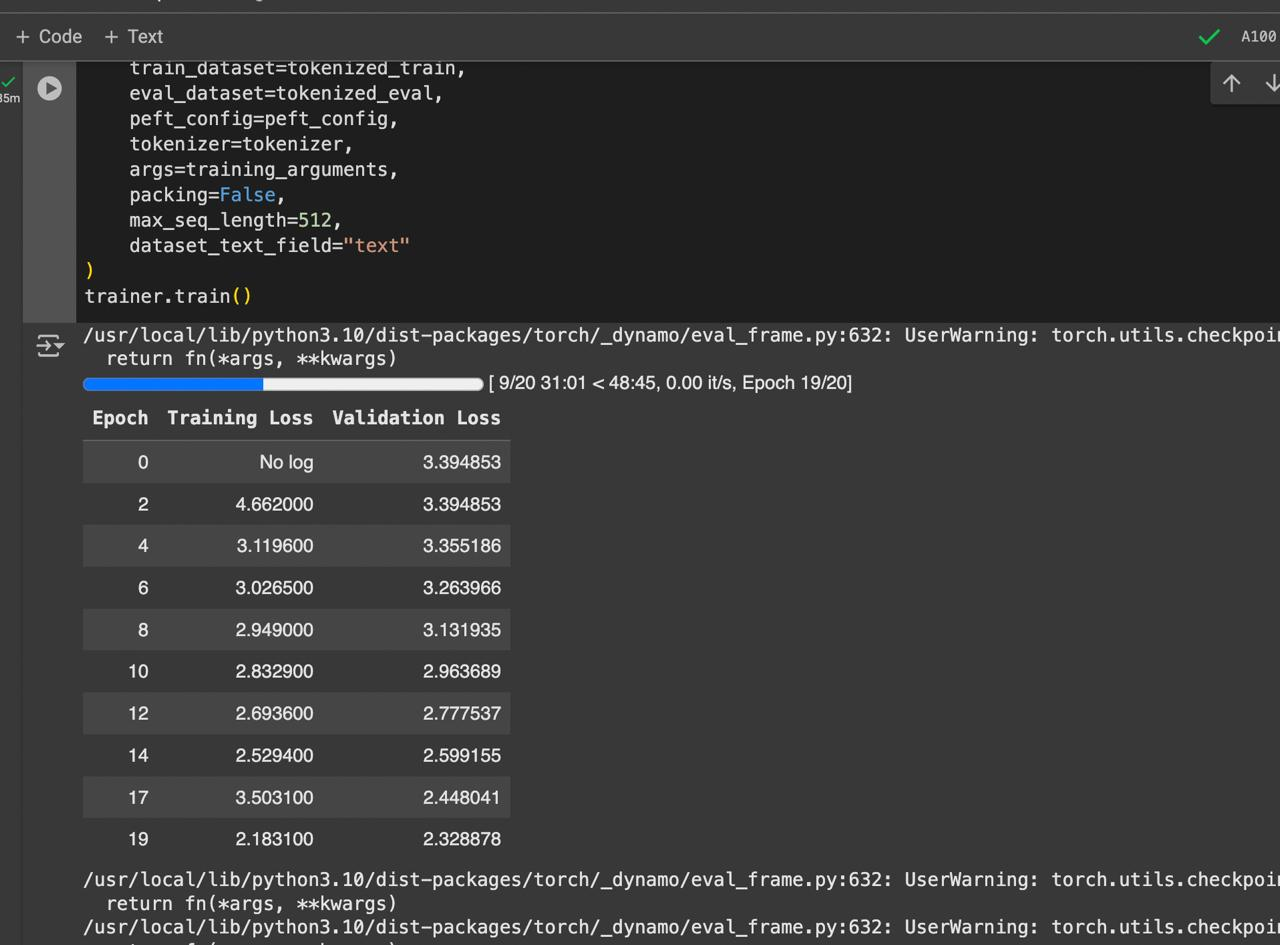)

In [ ]:
# Trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    max_seq_length=512,
    dataset_text_field="text"
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
0,3.294900,3.119032
1,3.123300,2.832937
2,2.747900,2.447318
3,2.375600,2.197354
4,2.154300,2.039923
5,2.001200,1.922332
6,1.878800,1.815920
7,1.756700,1.711478
8,1.650800,1.624956
9,1.566800,1.565546


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/

Epoch,Training Loss,Validation Loss
0,3.294900,3.119032
1,3.123300,2.832937
2,2.747900,2.447318
3,2.375600,2.197354
4,2.154300,2.039923
5,2.001200,1.922332
6,1.878800,1.815920
7,1.756700,1.711478
8,1.650800,1.624956
9,1.566800,1.565546


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/

TrainOutput(global_step=75, training_loss=1.6751314655939737, metrics={'train_runtime': 8110.2876, 'train_samples_per_second': 4.781, 'train_steps_per_second': 0.009, 'total_flos': 8.314862157598556e+17, 'train_loss': 1.6751314655939737, 'epoch': 24.489795918367346})

In [ ]:
# Save the model
trainer.model.save_pretrained("/content/drive/MyDrive/ESE-577-Model")
model.config.use_cache = True
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_

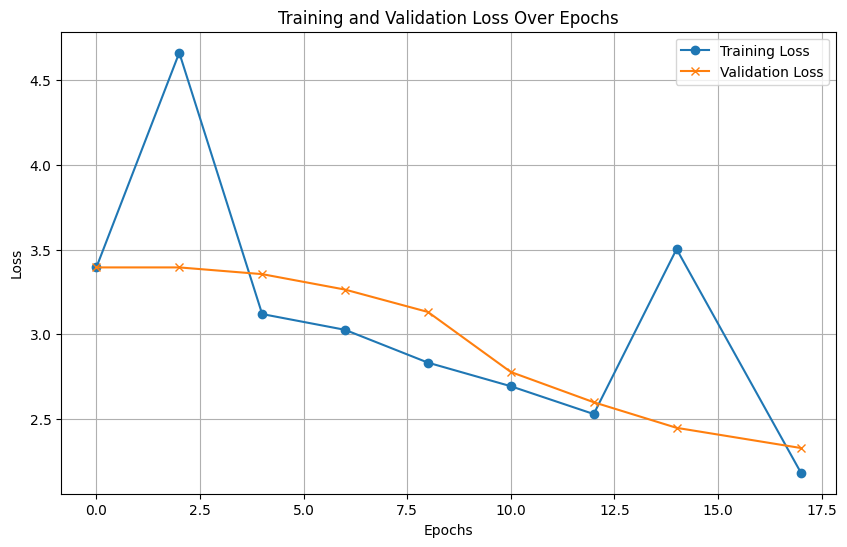

In [ ]:
import matplotlib.pyplot as plt

# Data: Epochs, Training Loss, and Validation Loss
epochs = [0, 2, 4, 6, 8, 10, 12, 14, 17]
train_losses = [
    3.394853, 4.662000, 3.119600, 3.026500, 2.832900,
    2.693600, 2.529400, 3.503100, 2.183100
]
val_losses = [
    3.394853, 3.394853, 3.355186, 3.263966, 3.131935,
    2.777537, 2.599155, 2.448041, 2.328878
]

# Plotting the data
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_losses, label="Training Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='x')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Show legend
plt.legend()

# Display grid
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Run the model locally
logging.set_verbosity(logging.CRITICAL)
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200, truncation=True)
def build_prompt(question):
    prompt = f"Question: {question}"
    return prompt

while True:
  question = input("Enter your ESE577-related question (hit Enter to exit): ").strip()
  if not question:
    break
  prompt = build_prompt(question)
  answer = pipe(prompt)
  print(answer)


[{'generated_text': "Question: What is the primary goal of a neural network?  A) To find the best-fit line for a given dataset B) To find the best-fit hyperplane for a given dataset C) To approximate complex non-linear relationships between inputs and outputs D) To find the correlation between input and output variables\n\nAnswer: C) To approximate complex non-linear relationships between inputs and outputs\n\nTags: ['linear_regression']\n\nTags: ['linear_regression_in_one_dimension']\n\nTags: ['linear_regression_in_multiple_dimensions']\n\nTags: ['linear_regression_in_multiple_dimensions:_derivation']\n\nTags: ['linear_regression_in_multiple_dimensions:_the_general_case']\n\nTags: ['linear_regression_in_multiple_dimensions:_the_general_case:_the_cost_function']"}]
[{'generated_text': "Question: What is the difference between a feedforward neural network and a recurrent neural network?\n\nAnswer: A feedforward neural network processes information in a single direction, from input to ou

In [ ]:
answer_extracted = answer[0]['generated_text'].split('Answer:')[1].split('\n')[0].strip()
print(answer_extracted)

Yes, it’s okay.  The weight update rule doesn’t need to include λ because it’s already included in the cost function.


In [ ]:
answer[0]['generated_text']

"Question: Is it okay that λ doesn’t appear weight update rule of ridge regression?\n\nAnswer: Yes, it’s okay.  The weight update rule doesn’t need to include λ because it’s already included in the cost function.\n\nTags: ['ridge_regression']\n\nTags: ['*']\n\nTags: ['ridge_regression_in_one_dimension']\n\nTags: ['ridge_regression_in_one_dimension:_derivation']\n\nTags: ['ridge_regression_in_one_dimension:_derivation:_the_weight_update_rule']\n\nTags: ['ridge_regression']\n\nTags: ['ridge_regression:_derivation']\n\nTags: ['ridge_regression:_derivation:_the_weight_update_rule']\n\nTags: ['ridge_regression:_deriv"

In [ ]:
questions = [
    "Is it okay that λ doesn’t appear weight update rule of ridge regression"
]

In [ ]:
device = "cuda"

In [ ]:
for question in questions:
    inputs = tokenizer(question, return_tensors="pt").to(device)
    outputs = model.generate(inputs["input_ids"], max_length=50)
    print(f"Post-Training Q: {question}")
    print(f"Post-Training A: {outputs[0]}")

# Evaluation Metrics

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    logging_dir="./logs",         # Directory for storing logs
    logging_steps=100,            # Adjust based on your dataset size
    save_strategy="epoch",        # Save checkpoints after every epoch
    num_train_epochs=5,           # Set the total number of epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,  # Optional: Load the best model at the end
)


In [ ]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

# Load the base model
base_model = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

mistral_model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)
mistral_model.config.use_cache = False
mistral_model.config.pretraining_tp = 1
mistral_model.gradient_checkpointing_enable()

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)

# Initialize the pipeline
mistral_pipe = pipeline(task="text-generation", model=mistral_model, tokenizer=tokenizer, max_length=200, truncation=True)

def build_prompt(question):
    return f"{question}"  # Direct question as prompt

# Interactive loop
print("Mistral-7B Chat (type your question, or press Enter to exit):")
while True:
    question = input("Enter your question: ").strip()
    if not question:
        break
    prompt = build_prompt(question)
    answer = mistral_pipe(prompt)
    print(answer[0]["generated_text"])
    print()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Mistral-7B Chat (type your question, or press Enter to exit):
Enter your question: can you generate a 5 question quiz on section 2.1
can you generate a 5 question quiz on section 2.1 of the textbook "Introduction to Database Systems" by Hector Garcia-Molina and Jeffrey D. Ullman?

I'd be happy to help you create a quiz on Section 2.1 of "Introduction to Database Systems" by Garcia-Molina and Ullman. Here are five potential questions:

1. What is a database, and what are its main components?
2. What is the difference between a schema and a database instance? Give an example of each.
3. Describe the role of a relational schema in a database system. What are the key components of a relational schema?
4. What is a primary key, and why is it important in a relational database? Give an example of a primary key.
5. Explain the concept of data normalization, and describe the benefits of normalizing

Enter your question: 


# Hyperparameter Tuning

In [ ]:
!pip install optuna

In [ ]:
!pip install transformers.integrations

In [ ]:
study.optimize(objective, n_trials=20, callbacks=[OptunaCallback()])

In [ ]:
import optuna
from transformers import TrainingArguments, Trainer


# Objective function for Optuna hyperparameter search
def objective(trial):
    # Define the hyperparameters to tune
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=trial.suggest_int('num_train_epochs', 3, 10),
        per_device_train_batch_size=trial.suggest_int('per_device_train_batch_size', 4, 8, 16),
        per_device_eval_batch_size=trial.suggest_int('per_device_eval_batch_size', 4, 8, 16),
        warmup_steps=trial.suggest_int('warmup_steps', 0, 200),
        weight_decay=trial.suggest_float('weight_decay', 0.0, 0.2),
        logging_dir="./logs",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        gradient_accumulation_steps=trial.suggest_int('gradient_accumulation_steps', 1, 16),
        fp16=True,
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-6, 1e-3),
        remove_unused_columns=False,
        push_to_hub=False
    )

    # Initialize the Trainer
    trainer = SFTTrainer(
        model=model,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_eval,
        peft_config=peft_config,
        tokenizer=tokenizer,
        args=training_args,
        packing=False,
        max_seq_length=512,
        dataset_text_field="text"
    )

    # Train the model and evaluate
    trainer.train()
    eval_results = trainer.evaluate()

    # Return the evaluation metric you want to optimize (e.g., eval_loss)
    return eval_results["eval_loss"]

# Create the Optuna study to optimize the objective function
study = optuna.create_study(direction="minimize")  # We want to minimize eval_loss
study.optimize(objective, n_trials=20)  # Run 20 trials

# Print the best hyperparameters found
print("Best hyperparameters: ", study.best_params)


# Let's Quiz!

The Gradient Descent Quiz -- Formatted Well

In [ ]:
"1.1 Gradient Descent Basics: Is this statement true? 'Gradient descent will always find a global optimum of any function.'",
    "1.1 Gradient Descent Basics: Is this statement true? 'Gradient descent, with an appropriate step size, can get arbitrarily close to a global optimum of any smooth convex function.'",
    "1.1 Gradient Descent Basics: Is this statement true? 'The step size η controls how much along the gradient we descend in each step.'",

    # 1.2
    "1.2 Gradient Descent Update Rule: Calculate the update rule for θ when performing gradient descent on f(θ) = (2θ + 3)^2, using η as a step size parameter. Provide the update rule in terms of θ and η.",
    "1.3 Starting with θ = 1 and η = 0.1, what is the value of f(θ) = (2θ + 3)^2 before running any iterations of gradient descent?",
    "1.4 After a single gradient descent update, starting with θ = 1 and η = 0.1, what is the value of θ? Use the formula θ_new = θ - η * ∇θf(θ), and continue with θ = 1 and η = 0.1.",
    "1.5 After the update in 1.4, what is the value of f(θ) = (2θ + 3)^2?"

    #2.1
    "2.1 For very small step size η, what will generally be true? Choose one of the following: (a) f(θ_t-1) ≥ f(θ_t), (b) f(θ_t-1) ≤ f(θ_t), (c) Cannot say.",
    "2.2 For very large step size η, what will generally be true? Choose one of the following: (a) f(θ_t-1) ≥ f(θ_t), (b) f(θ_t-1) ≤ f(θ_t), (c) Cannot say.",
    "2.3 When using the optimal step-size rule η* = argmin_η f(θ_t-1 − η∇θf(θ_t-1)), what will generally be true? Choose one of the following: (a) f(θ_t-1) ≥ f(θ_t), (b) f(θ_t-1) ≤ f(θ_t), (c) Cannot say.",
    "2.4 Check all that are true about the approach in 2.3 for selecting η*: (a) The approach is guaranteed to converge to a global minimum. (b) The approach is efficient in that it will generally converge to a local optimum in fewer gradient descent steps relative to a fixed step size. (c) The approach is inefficient in that it may require a lot of computation to find η* at each gradient descent step."

]

In [ ]:
"False",  # 1.1 - Second statement
    "True",  # 1.1 - Third statement
    "True",  # 1.1 - Fourth statement
    "θ_new = θ - η * 4 * (2θ + 3)"  # 1.2 - Update Rule
    "25",  # 1.3
    "-1",  # 1.4
    "1",   # 1.5
    "(a)",  # 2.1
    "(c)",  # 2.2
    "(a)",  # 2.3
    "(b), (c)"  # 2.4
]

In [ ]:
gradient_descent_quiz_questions = [
    # 1.1
    "1.1 Gradient Descent Basics: Is this statement true? 'If gradient descent satisfies its termination criterion (other than stopping after a number of iterations), then it will generally be close to a point where the gradient is zero.'Answer in only True or False"]


gradient_descent_correct_answers = [
    # 1.1
    "True",  # 1.1 - First statement
]


In [ ]:
def evaluate_models(questions, correct_answers, mistral_pipeline, trained_pipeline):
    scores = {"Mistral": 0, "Trained": 0}
    total = len(questions)

    for i, (question, correct_answer) in enumerate(zip(questions, correct_answers), 1):
        prompt = build_prompt(question)

        # Get answers from both models
        mistral_answer = mistral_pipeline(prompt)[0]["generated_text"]
        trained_answer = trained_pipeline(prompt)[0]["generated_text"]

        # Evaluate answers
        mistral_correct = correct_answer in mistral_answer
        trained_correct = correct_answer in trained_answer

        # Update scores
        scores["Mistral"] += int(mistral_correct)
        scores["Trained"] += int(trained_correct)

        # Print question, correct answer, and responses
        print(f"Question {i}: {question}")
        print(f"Correct Answer: {correct_answer}")
        print(f"Mistral Model Answer: {mistral_answer} {'(Correct)' if mistral_correct else '(Incorrect)'}")
        print(f"Trained Model Answer: {trained_answer} {'(Correct)' if trained_correct else '(Incorrect)'}")
        print("\n" + "-"*50 + "\n")

    # Print final scores
    print("Final Scores:")
    print(f"Mistral Model: {scores['Mistral']}/{total}")
    print(f"Trained Model: {scores['Trained']}/{total}")

# Call the function
evaluate_models(gradient_descent_quiz_questions, gradient_descent_correct_answers , mistral_pipe, pipe)


Question 1: 1.1 Gradient Descent Basics: Is this statement true? 'If gradient descent satisfies its termination criterion (other than stopping after a number of iterations), then it will generally be close to a point where the gradient is zero.'Answer in only True or False
Correct Answer: True
Mistral Model Answer: 1.1 Gradient Descent Basics: Is this statement true? 'If gradient descent satisfies its termination criterion (other than stopping after a number of iterations), then it will generally be close to a point where the gradient is zero.'Answer in only True or False.

False. Gradient descent may converge to a local minimum or a saddle point, where the gradient is not zero. It may also diverge if the learning rate is too large. The termination criterion only ensures that the algorithm stops when a certain condition is met, such as reaching a certain error threshold or a maximum number of iterations. It does not guarantee that the algorithm has reached a global minimum or a point w